In [1]:
from pymatgen.io.vasp import Xdatcar
import matplotlib.pyplot as plt
import numpy as np
import yaml
from scipy.stats import geom, poisson

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, get_structures, indices_by_species

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
def merge_strings(strings):
    finished = False
    while not finished:
        finished = True
        for s1 in strings:
            for s2 in strings:
                if s1 == s2:
                    continue
                if s2[0] == s1[-1]:
                    s1.extend(s2)
                    strings.remove(s2)
                    finished = False
                    break
                elif s2[-1] == s1[0]:
                    s2.extend(s1)
                    strings.remove(s1)
                    finished = False
                    break
    return strings

In [4]:
from collections import Counter
from copy import copy

class String(object):
    
    def __init__(self, sites):
        self.sites = sites
        
    def __eq__(self, other):
        return self.sites == other.sites
    
    def __getitem__(self, index):
        return self.sites[index]
    
    def __iter__(self):
        yield self.sites
        
    def extend(self, other):
        assert(self[-1] == other[0])
        self.sites.extend( other[1:] )
        
    def is_closed(self):
        return self.sites[0] == self.sites[-1]
    
    def __len__(self):
        return np.unique(self.sites).shape[0]
    
class StringCollection(object):
    
    def __init__(self, strings, timestep=None):
        self.strings = strings
        self.merged_strings = merge_strings(strings)
        self.timestep = timestep
        
    def string_lengths(self):
        return [ len(s) for s in self.merged_strings ]

    def closed(self):
        return [ s.is_closed() for s in self.merged_strings ]
    
    def __add__(self, other):
        summed_string_data = copy(self)
        summed_string_data.strings = self.strings + other.strings
        summed_string_data.merged_strings = self.merged_strings + other.merged_strings
        return summed_string_data
    
    def __iadd__(self, other):
        return self + other
    
    def length_counter(self):
        return Counter(self.string_lengths())
        

In [5]:
def find_length_2_strings(dr_ij, cutoff=1.0):
    strings = []
    for i, dr_i in enumerate(dr_ij):
        if dr_i[i] < cutoff: # distance moved by atom i
            continue
        where = np.where(dr_i < cutoff )[0]
        if where.size > 0:
#             print(i, where, dr_i[i], dr_i[where[0]])
            strings.append(String(sites=[i, where[0]]))
#             print(strings[-1].sites)
    return strings

data_dir = '../../data/'

d_steps_list = [10, 20, 30, 40, 50]
string_data_dt = {}
for system in md_runs:
    string_data_dt[system] = {}
    for disorder, runs in md_runs[system].items():
        print(f'{system} {disorder} inherent')
        string_data_dt[system][disorder] = {}
        for d_steps in d_steps_list:
            xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
            xdatcars = (Xdatcar( f ) for f in xdatcar_filenames)
            structures = flatten_list( [ x.structures for x in xdatcars ] )
            li_indices = indices_by_species( structures[0], 'Li' )
            lattice = structures[0].lattice
            all_strings = []
            for t, (struc_i, struc_j) in enumerate(zip( structures[:len(structures)-d_steps], 
                                                     structures[d_steps:]) ):
                i_frac_coords = struc_i.frac_coords[li_indices]
                j_frac_coords = struc_j.frac_coords[li_indices]
                dr_ij = lattice.get_all_distances(i_frac_coords, j_frac_coords)
                string_data = StringCollection(find_length_2_strings(dr_ij), timestep=t)
#                 for s in string_data.strings:
#                     print(s.sites)
                if string_data.length_counter()[13]:
                    s13 = [ s for s in string_data.merged_strings if len(s)==13 ]
                    print(s13[0].sites)
                    print(t)
                if not all_strings:
                    all_strings = string_data
                else:
                    all_strings += string_data
            string_data_dt[system][disorder][d_steps] = all_strings


Li6PS5I 0p inherent
Li6PS5I 50p inherent
Li6PS5I 100p inherent
Li6PS5Cl 0p inherent
Li6PS5Cl 50p inherent
[32, 90, 66, 138, 98, 184, 18, 42, 142, 115, 146, 162, 154]
97
[164, 24, 2, 49, 34, 80, 141, 40, 57, 168, 117, 89, 19]
394
Li6PS5Cl 100p inherent


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


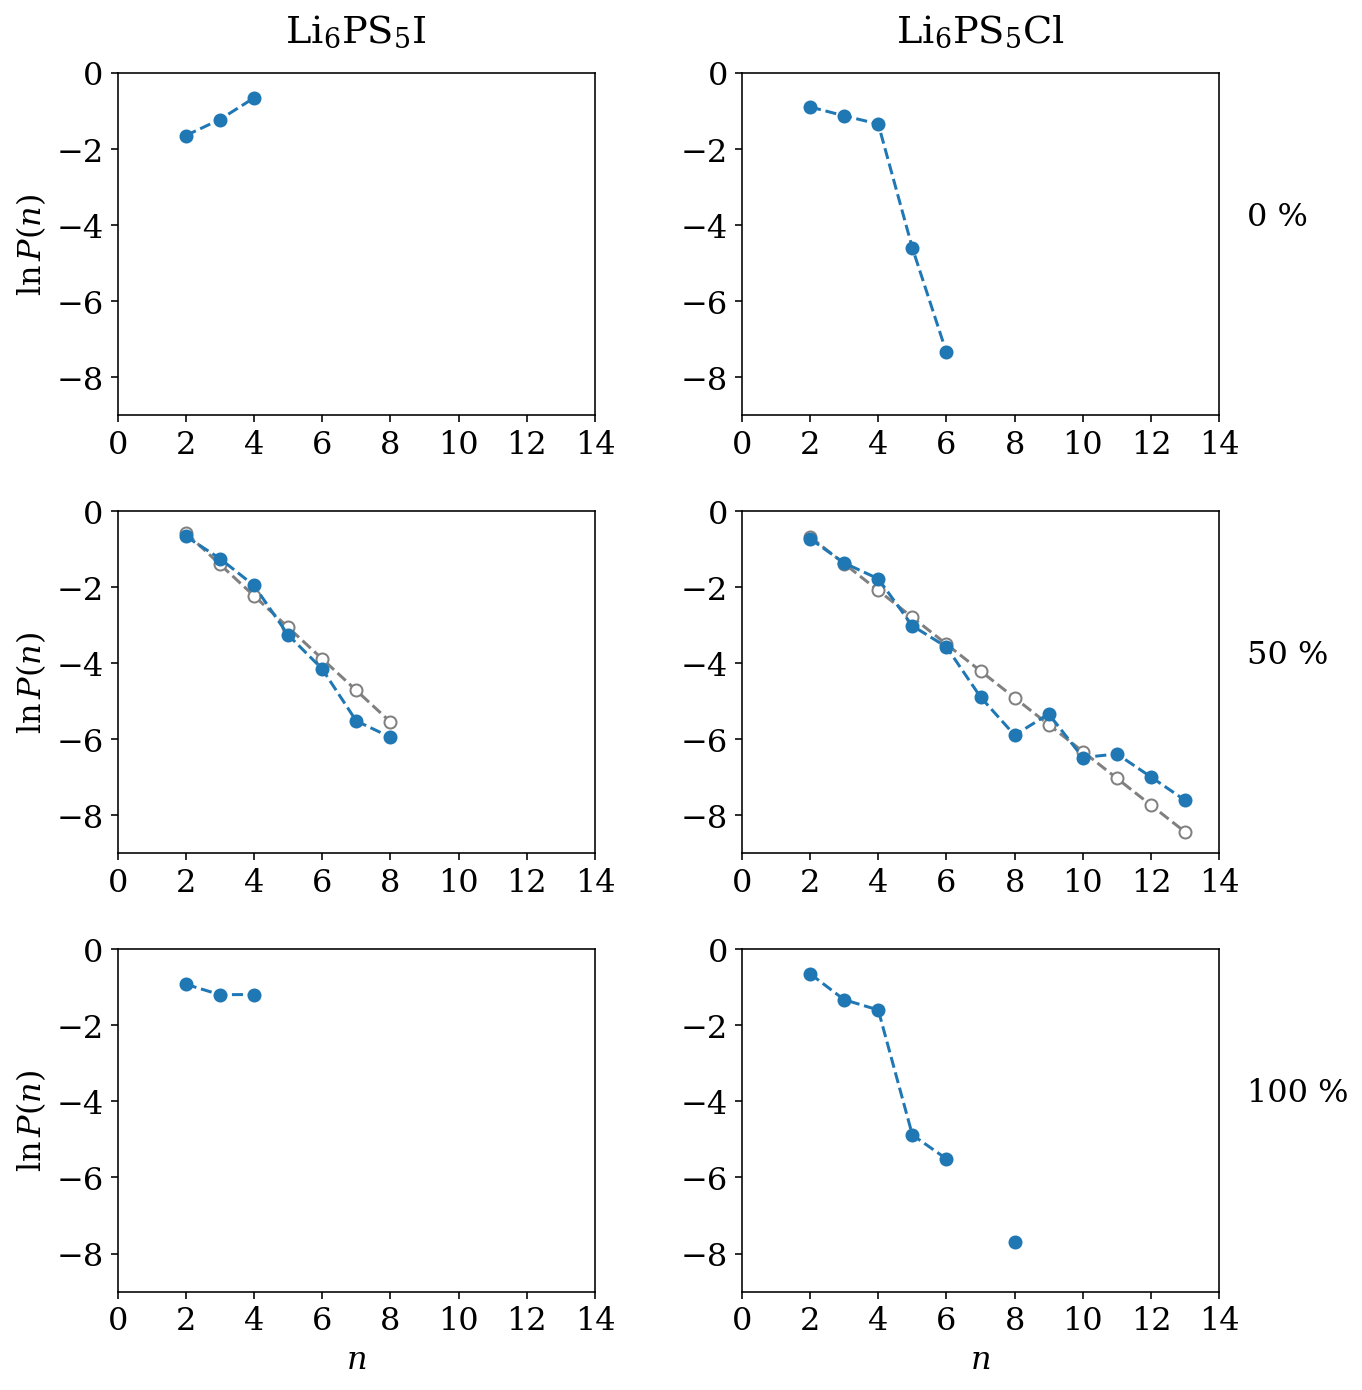

In [46]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['font.size'] = 16
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'dejavuserif'

xlabel = r'$n$'
ylabel = r'$\ln\,P(n)$'

def plot_string_lengths(string_data, axes, label=None):
    count = string_data.length_counter()
    for i in range(12):
        if i not in count.keys():
            count[i] = 0
    labels, values = zip(*sorted(count.items()))
    values = np.array(values)*np.arange(len(values))
    normalised_values = np.array([ v/sum(values) for v in values])
    indexes = np.arange(len(labels))
    axes.plot(indexes, np.log(normalised_values), 'o--')
              
sigma = 0.1
fig, ax = plt.subplots(3,2,figsize=(10,10))

for i in [50]:
    label = r'$\Delta t =$' + str(i/10) + ' ps'
    plot_string_lengths(string_data_dt['Li6PS5I']['0p'][i], axes=ax[0,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['50p'][i], axes=ax[1,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5I']['100p'][i], axes=ax[2,0], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['0p'][i], axes=ax[0,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['50p'][i], axes=ax[1,1], label=label)
    plot_string_lengths(string_data_dt['Li6PS5Cl']['100p'][i], axes=ax[2,1], label=label)

y_max = 3
for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim([0,14])
        ax[i,j].set_ylim([-9,0])

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(range(0,15,2))
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel)

ax[0,1].text(14.8,-4,'0 %')
ax[1,1].text(14.8,-4,'50 %')
ax[2,1].text(14.8,-4,'100 %')

x = np.arange(2,14)
estimate = geom.pmf(x, p=0.50591697, loc=1)
ax[1,1].plot(x, np.log(estimate), 'o--', c='grey', zorder=0, markerfacecolor='white', markeredgecolor='grey')

x = np.arange(2,9)
estimate = geom.pmf(x, p=0.56319932, loc=1)
ax[1,0].plot(x, np.log(estimate), 'o--', c='grey', zorder=0, markerfacecolor='white', markeredgecolor='grey')


    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/string_populations.pdf', tight_layout=True)
fig.show()

[-0.68138271 -1.38643441 -2.09148611 -2.79653781 -3.50158951 -4.20664121
 -4.91169291 -5.61674461 -6.32179631 -7.02684801 -7.7318997  -8.4369514 ]


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


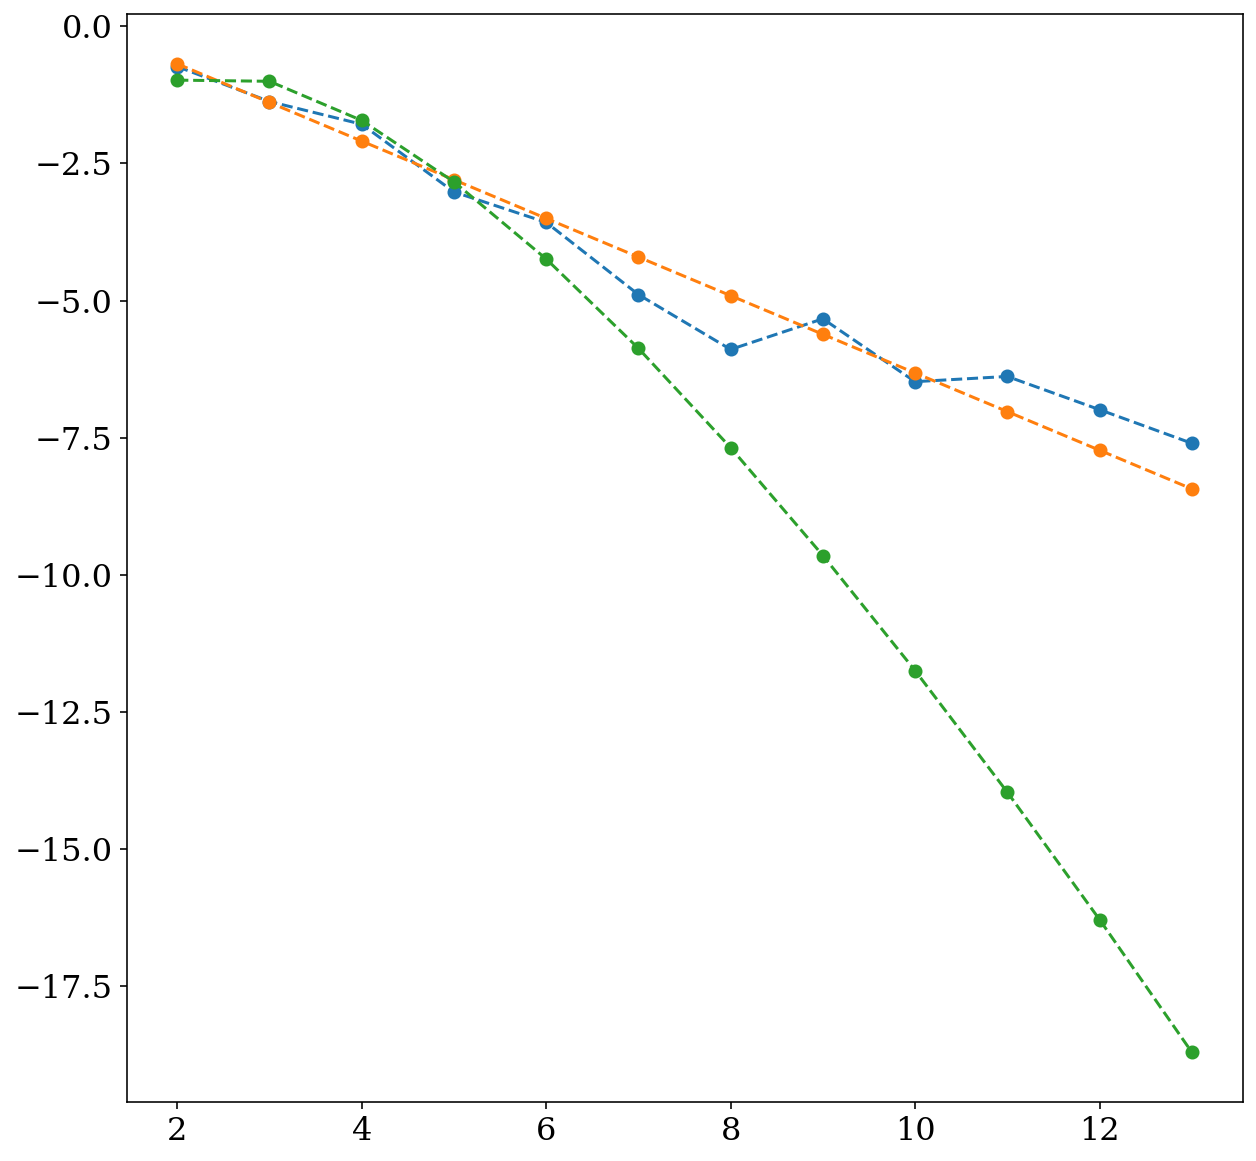

In [102]:
from scipy.stats import geom, poisson
sigma = 0.1
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in [50]:
    plot_string_lengths(string_data_dt['Li6PS5Cl']['50p'][i], axes=ax, label=label)

x = np.arange(2,14)
estimate = geom.pmf(x, p=0.50591697, loc=1)
print(np.log(estimate))
ax.plot(x, np.log(estimate), 'o--')

estimate2 = poisson.pmf(x, mu=0.97900887, loc=2)
ax.plot(x, np.log(estimate2), 'o--')

[-0.57412168 -1.40239998 -2.23067828 -3.05895657 -3.88723487 -4.71551317
 -5.54379147 -6.37206977 -7.20034806 -8.02862636 -8.85690466 -9.68518296]


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


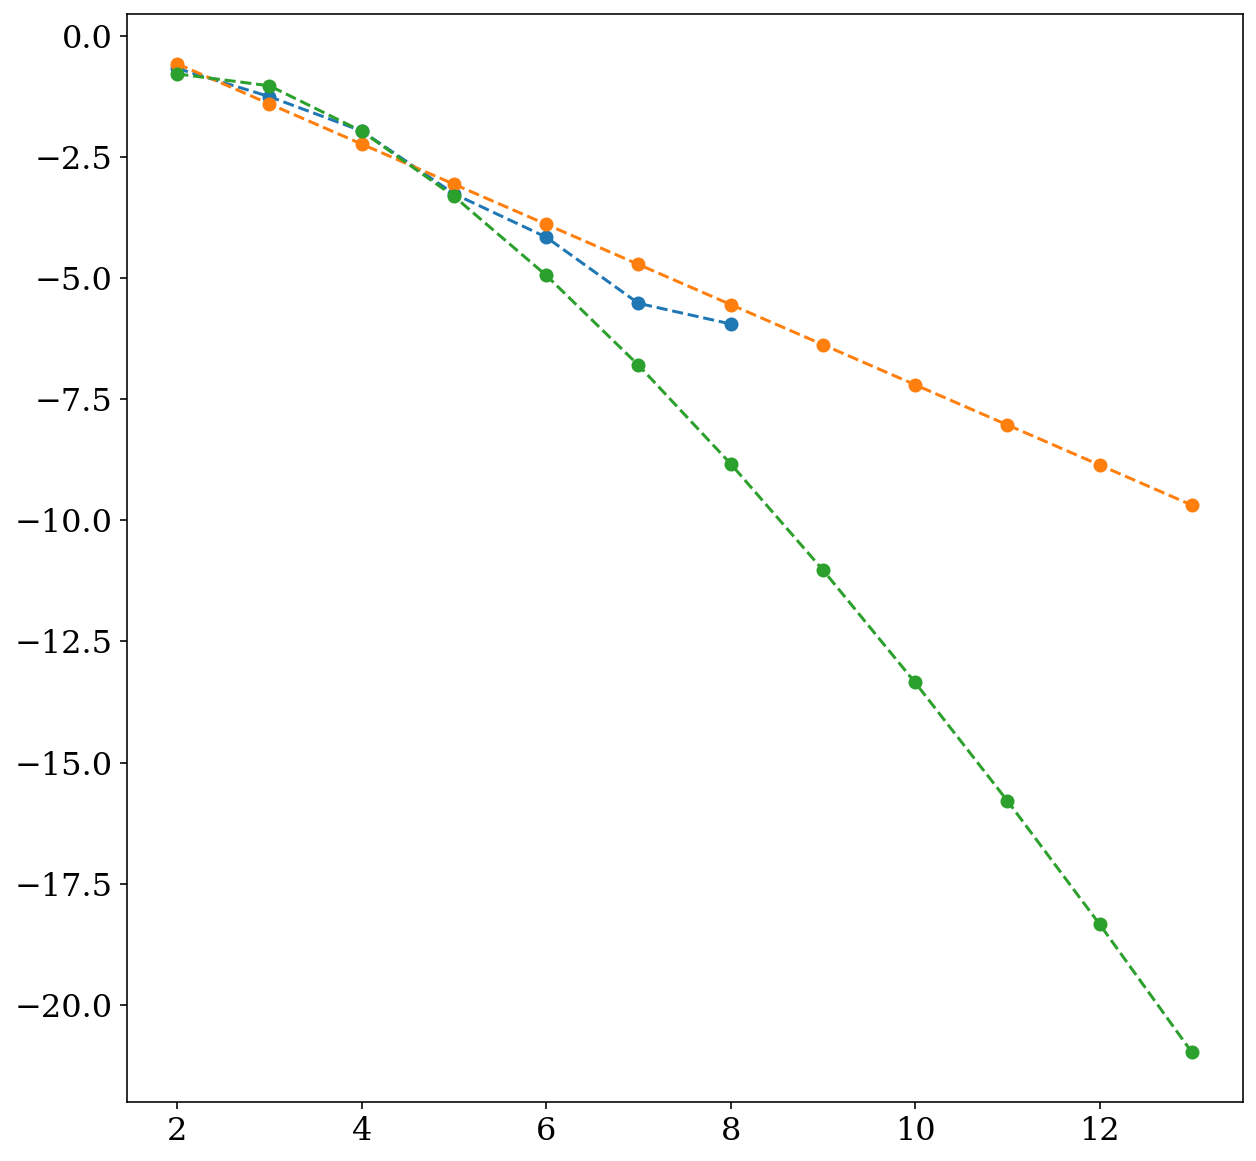

In [48]:
from scipy.stats import geom, poisson
sigma = 0.1
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in [50]:
    plot_string_lengths(string_data_dt['Li6PS5I']['50p'][i], axes=ax, label=label)

x = np.arange(2,14)
estimate = geom.pmf(x, p=0.56319932, loc=1)
print(np.log(estimate))
ax.plot(x, np.log(estimate), 'o--')

estimate2 = poisson.pmf(x, mu=0.78269886, loc=2)
ax.plot(x, np.log(estimate2), 'o--')

In [49]:
### from scipy.stats import geom, poisson

In [50]:
sd = string_data_dt['Li6PS5I']['50p'][50]

In [51]:
data = np.array(flatten_list([ [k]*v*k for k, v in sd.length_counter().items()]))

In [52]:
from scipy.optimize import differential_evolution
from scipy.stats import geom, poisson

def negLogLikelihood_pois(params, data):
    lnl = -np.sum(np.log(poisson.pmf(data, params[0], loc=int(round(params[1])))))
    return lnl

def negLogLikelihood_geom(params, data):
    lnl = -np.sum(np.log(geom.pmf(data, params[0], loc=int(round(params[1])))))
    return lnl

result = differential_evolution(negLogLikelihood_geom,  
                  args=(data,),
                  bounds=((0,1),(0,5)))
print(result)

result = differential_evolution(negLogLikelihood_pois,  
                  args=(data,),
                  bounds=((0,5),(0,5)))
print(result)

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


     fun: 14923.367417142954
 message: 'Optimization terminated successfully.'
    nfev: 309
     nit: 9
 success: True
       x: array([0.56168304, 1.36446061])
     fun: 14990.911268907108
     jac: array([0.00964064, 0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 432
     nit: 13
 success: True
       x: array([0.78176225, 2.23034811])


In [53]:
sd.length_counter().items()

dict_items([(2, 3129), (5, 94), (4, 430), (3, 1165), (6, 32), (7, 7), (8, 4)])

(array([6258., 3495.,    0., 1720.,    0.,  470.,  192.,    0.,   49.,
          32.]),
 array([2. , 2.6, 3.2, 3.8, 4.4, 5. , 5.6, 6.2, 6.8, 7.4, 8. ]),
 <a list of 10 Patch objects>)

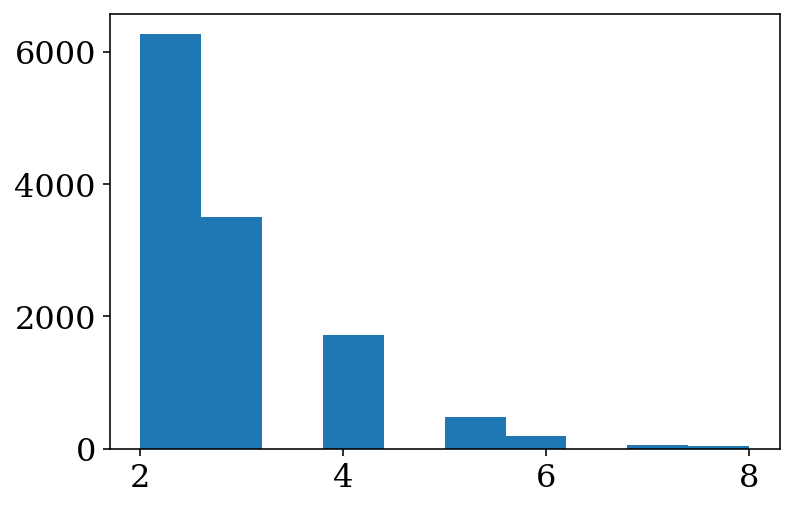

In [54]:
plt.hist(data)

In [55]:
data

array([2, 2, 2, ..., 8, 8, 8])

[        -inf         -inf  -0.4699157   -1.45089152  -2.43186734
  -3.41284317  -4.39381899  -5.37479482  -6.35577064  -7.33674646
  -8.31772229  -9.29869811 -10.27967393]


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


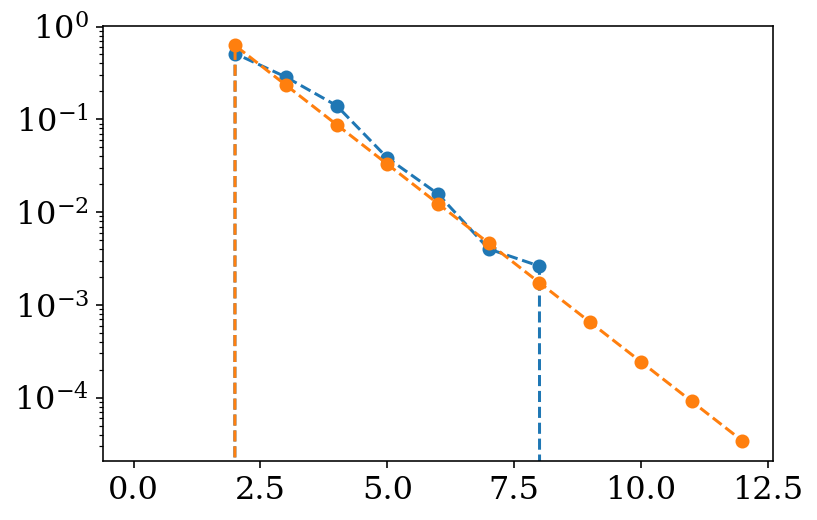

In [103]:
count = Counter(data)
for i in range(12):
    if i not in count.keys():
        count[i] = 0
labels, values = zip(*sorted(count.items()))
values = np.array(values)
# values = np.array(values)*np.arange(len(values))
normalised_values = np.array([ v/sum(values) for v in values])
#     normalised_values *= np.arange(len(normalised_values))
indexes = np.arange(len(labels))
# plt.plot(indexes, normalised_values, 'o--')
# plt.plot(indexes, values/20000, 'o--')
# plt.hist(data, density=True, bins=13)
plt.semilogy(indexes, normalised_values, 'o--')
x = np.arange(13)
estimate = geom.pmf(x, p=0.62505496, loc=1)
print(np.log(estimate))
plt.semilogy(x, estimate, 'o--')

In [104]:
values

array([   0,    0, 6258, 3495, 1720,  470,  192,   49,   32,    0,    0,
          0])

[        -inf         -inf  -0.37106368  -1.54224666  -2.71342964
  -3.88461263  -5.05579561  -6.22697859  -7.39816157  -8.56934455
  -9.74052753 -10.91171051 -12.0828935 ]


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


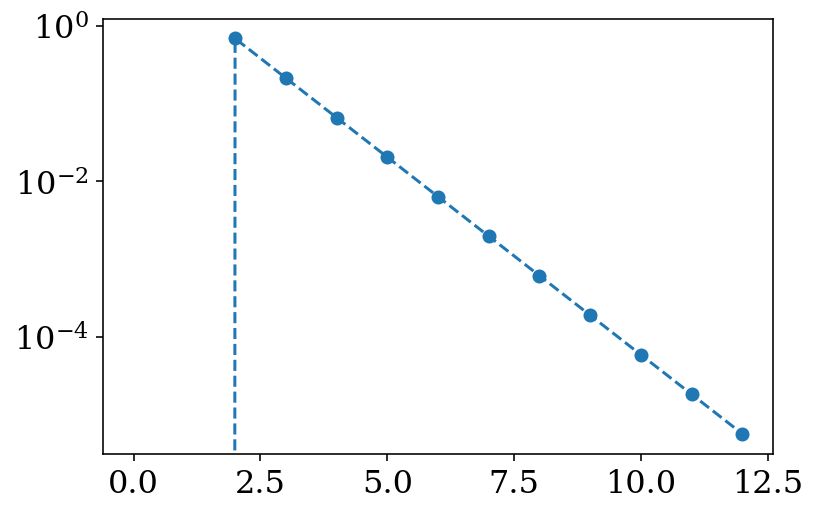

In [105]:
x = np.arange(13)
estimate = geom.pmf(x, p=0.69, loc=1)
print(np.log(estimate))
plt.semilogy(x, estimate, 'o--')

In [106]:
int(round(0.9))

1

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from scipy.special import factorial
from dynesty import plotting as dyplot

In [108]:
def poisson(x, l, loc=2):
    return l ** (x - loc) * np.exp(-l) / factorial((x - loc))

In [109]:
def geometric(x, p, loc=1):
    return (1 - p) ** ((x - loc) - 1) * p

In [110]:
class GetEvidence():
    def __init__(self, x, y, model, bounds=((0, 1)), dy=None):
        self.x = x
        self.y = y
        self.dy = dy
        self.model = model
        self.bounds = bounds
        self.evidence = None
        
    def nlogl(self, p):
        if self.dy is None:
            return -0.5 * np.sum(
                np.square(self.y - self.model(self.x, p[0])))
        else:
            return -0.5 * np.sum(
                np.square(self.y - self.model(self.x, p[0])) / self.dy)
        
    def ptform(self, uniform):
        priors = []
        for i in range(len(self.bounds)):
            priors.append(
                self.bounds[i][0] + (
                    self.bounds[i][1] - self.bounds[i][0]) * uniform[i])
        return priors
    
    def evidence_estimator(self):
        self.sampler = dynesty.NestedSampler(self.nlogl, self.ptform, 2)
        self.sampler.run_nested()
        self.evidence = self.sampler.results['logz'][-1]
        self.evidence_err = self.sampler.results['logzerr'][-1]

In [111]:
data

array([2, 2, 2, ..., 8, 8, 8])

[       -inf        -inf -0.4699157  -1.45089152 -2.43186734 -3.41284317
 -4.39381899 -5.37479482 -6.35577064]


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


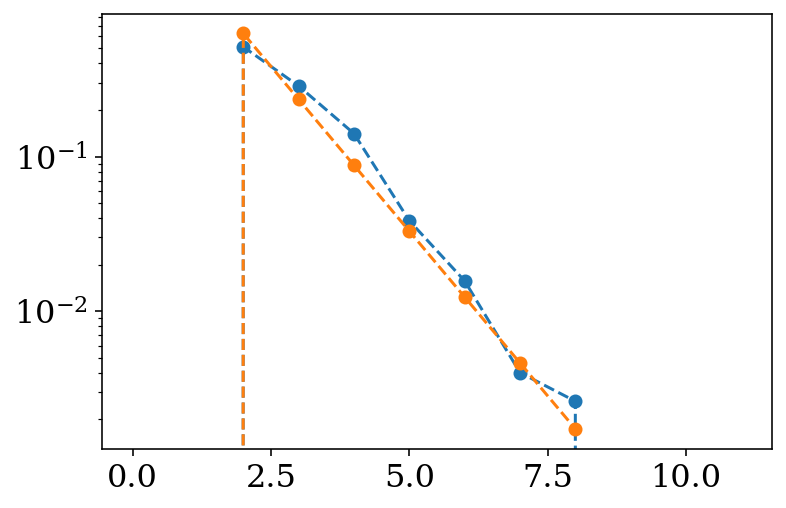

In [112]:
count = Counter(data)
for i in range(12):
    if i not in count.keys():
        count[i] = 0
labels, values = zip(*sorted(count.items()))
values = np.array(values)
# values = np.array(values)*np.arange(len(values))
normalised_values = np.array([ v/sum(values) for v in values])
#     normalised_values *= np.arange(len(normalised_values))
indexes = np.arange(len(labels))
# plt.plot(indexes, normalised_values, 'o--')
# plt.plot(indexes, values/20000, 'o--')
# plt.hist(data, density=True, bins=13)
plt.semilogy(indexes, normalised_values, 'o--')
x = np.arange(9)
estimate = geom.pmf(x, p=0.62505496, loc=1)
print(np.log(estimate))
plt.semilogy(x, estimate, 'o--')

In [113]:
indexes[2:], normalised_values[2:]

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0.51227898, 0.2861002 , 0.14079895, 0.03847413, 0.01571709,
        0.00401113, 0.00261952, 0.        , 0.        , 0.        ]))

In [114]:
p_estimator = GetEvidence(indexes[2:], normalised_values[2:], poisson, bounds=[[0,5]])

In [115]:
p_estimator.evidence_estimator()

511it [00:00, 3245.35it/s, +500 | bound: 0 | nc: 1 | ncall: 1412 | eff(%): 71.601 | loglstar:   -inf < -0.002 <    inf | logz: -0.116 +/-    nan | dlogz:  0.001 >  0.509]


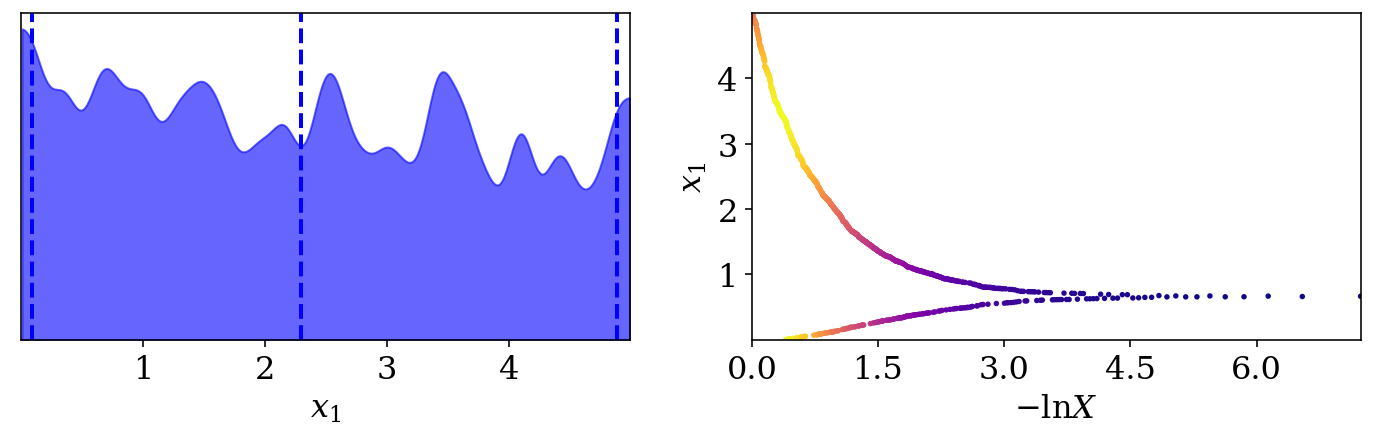

In [116]:
dyplot.traceplot(p_estimator.sampler.results)
plt.show()

In [117]:
print('The evidence for model {} with the data is: {:.3f}+/-{:.3f}'.format(
    p_estimator.model, p_estimator.evidence, p_estimator.evidence_err))

The evidence for model <function poisson at 0x135aaa620> with the data is: -0.116+/-nan


In [118]:
g_estimator = GetEvidence(indexes[2:], normalised_values[2:], geometric, bounds=[[0,1]])

In [119]:
g_estimator.evidence_estimator()

488it [00:00, 3617.82it/s, +500 | bound: 0 | nc: 1 | ncall: 1285 | eff(%): 76.887 | loglstar:   -inf < -0.001 <    inf | logz: -0.060 +/-    nan | dlogz:  0.001 >  0.509]


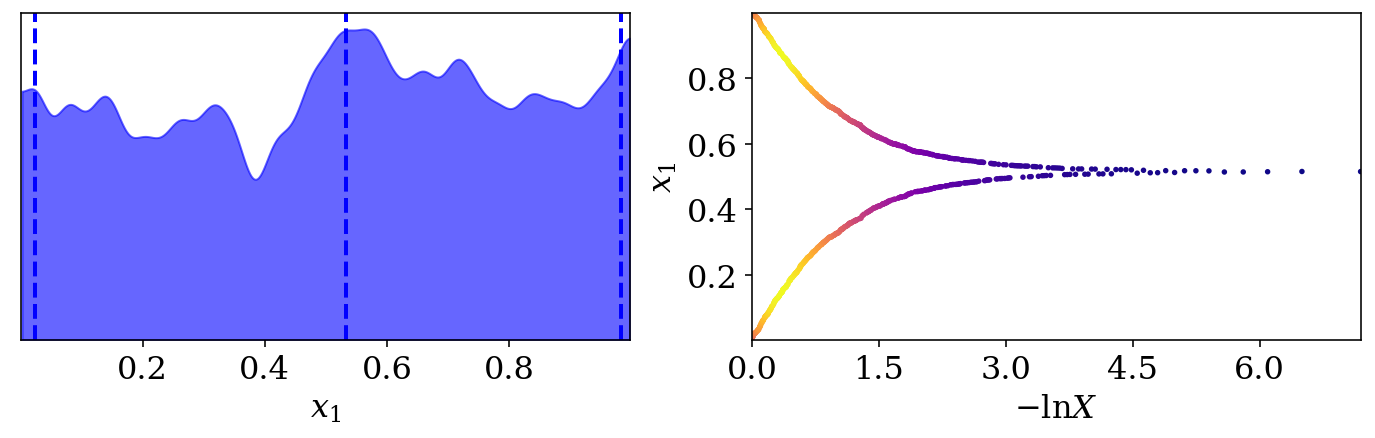

In [120]:
dyplot.traceplot(g_estimator.sampler.results)
plt.show()

In [121]:
print('The evidence for model {} with the data is: {:.3f}+/-{:.3f}'.format(
    g_estimator.model, g_estimator.evidence, g_estimator.evidence_err))

The evidence for model <function geometric at 0x135aaaf28> with the data is: -0.060+/-nan


In [122]:
bayes = 2 * (g_estimator.evidence - p_estimator.evidence)

In [123]:
bayes

0.11247598408969961

In [76]:
indexes,normalised_values

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0.        , 0.        , 0.51227898, 0.2861002 , 0.14079895,
        0.03847413, 0.01571709, 0.00401113, 0.00261952, 0.        ,
        0.        , 0.        ]))

In [77]:
data

array([2, 2, 2, ..., 8, 8, 8])

In [78]:
from random import choices
def bootstrap(data, nsamples):
    return np.array([ choices(data, k=len(data)) for i in range(nsamples) ])
    

In [79]:
np.unique(data, return_counts=True)

(array([2, 3, 4, 5, 6, 7, 8]),
 array([6258, 3495, 1720,  470,  192,   49,   32]))

In [80]:
d = bootstrap(data, 10000)
db = np.vstack([np.unique(a, return_counts=True)[1] for a in d])
db

array([[6272, 3452, 1763, ...,  170,   47,   34],
       [6300, 3439, 1705, ...,  200,   49,   36],
       [6229, 3482, 1764, ...,  186,   47,   36],
       ...,
       [6179, 3508, 1770, ...,  206,   56,   36],
       [6281, 3516, 1706, ...,  197,   42,   31],
       [6220, 3517, 1742, ...,  186,   50,   28]])

In [81]:
np.mean(db, axis=0)

array([6257.923 , 3494.8942, 1720.2939,  470.0433,  191.9767,   48.982 ,
         31.8869])

(array([  2.,   0.,   2.,   6.,   5.,   4.,   7.,  21.,  23.,  19.,  42.,
         57.,  71., 102., 108., 149., 196., 218., 286., 283., 368., 396.,
        463., 534., 491., 584., 609., 554., 599., 472., 505., 477., 429.,
        386., 277., 285., 197., 180., 148., 123.,  82.,  83.,  52.,  39.,
         14.,  20.,  13.,   4.,  11.,   4.]),
 array([6048. , 6055.8, 6063.6, 6071.4, 6079.2, 6087. , 6094.8, 6102.6,
        6110.4, 6118.2, 6126. , 6133.8, 6141.6, 6149.4, 6157.2, 6165. ,
        6172.8, 6180.6, 6188.4, 6196.2, 6204. , 6211.8, 6219.6, 6227.4,
        6235.2, 6243. , 6250.8, 6258.6, 6266.4, 6274.2, 6282. , 6289.8,
        6297.6, 6305.4, 6313.2, 6321. , 6328.8, 6336.6, 6344.4, 6352.2,
        6360. , 6367.8, 6375.6, 6383.4, 6391.2, 6399. , 6406.8, 6414.6,
        6422.4, 6430.2, 6438. ]),
 <a list of 50 Patch objects>)

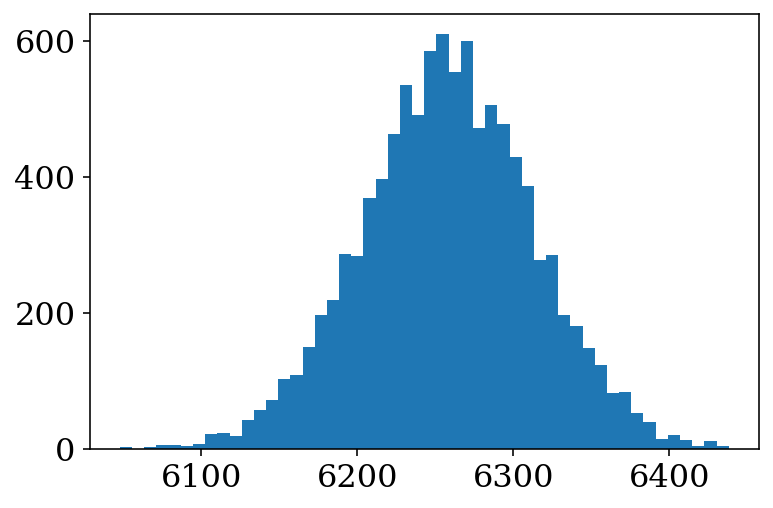

In [82]:
plt.hist(db[:,0], bins=50)

In [83]:
np.std(db, axis=0)

array([55.02276321, 50.26697332, 38.39178978, 21.45617452, 13.69006783,
        7.03355358,  5.61026812])

In [84]:
dy = np.array([80.6670156 , 69.87419781, 60.54165553, 34.5895372 , 26.47013165,
       13.97802434,  8.34584713, 11.18835264,  6.32483025,  6.57990978,
        4.93755443,  3.62878784])

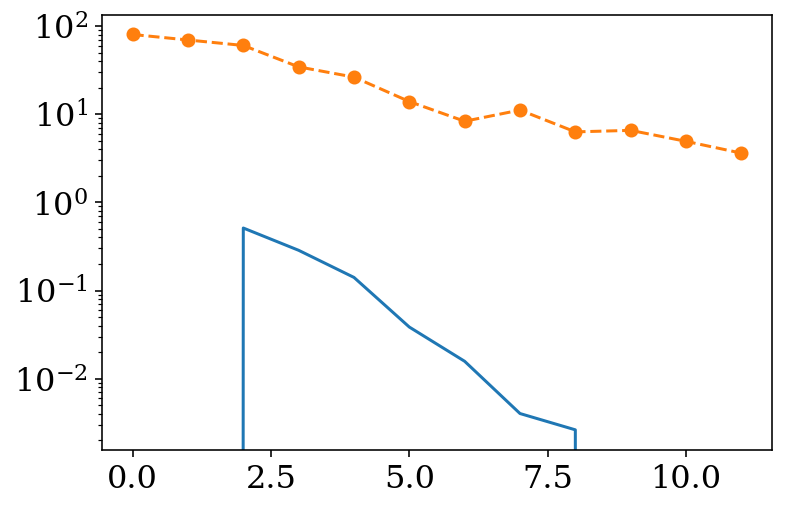

In [85]:
plt.semilogy(indexes, normalised_values, dy, 'o--')

In [86]:
plt.plot?

NameError: name 'dyn' is not defined

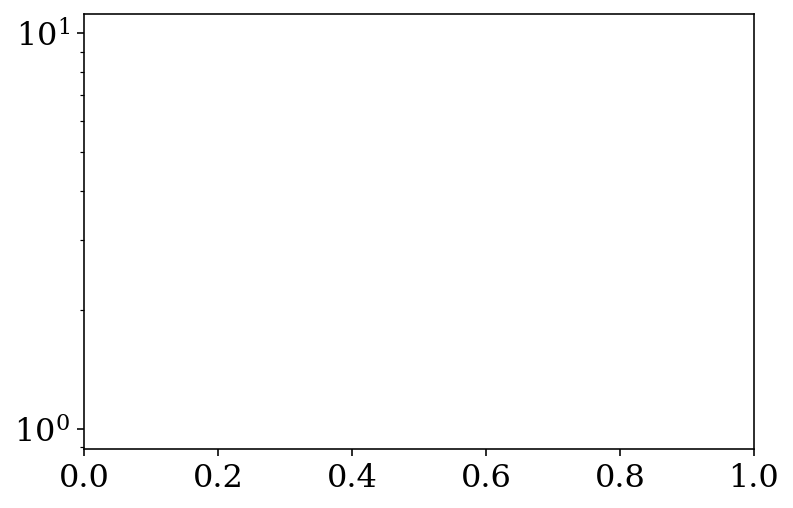

In [87]:
# with errorbars: clip non-positive values
ax = plt.subplot(111)
# ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

x = indexes
y = normalised_values
plt.errorbar(x[2:], y[2:], yerr=dyn*2, fmt='o--')
ax.set_ylim(ymin=1e-4)

In [ ]:
dy

In [ ]:
plt.errorbar?

In [ ]:
dyn = np.array([ y/sum(values) for y, v in zip(dy, values)])

In [ ]:
)